In [1]:
import pandas as pd

import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

## Supplementary Figure S1A: Comparison of measurements between barcode and extended primers


In [15]:
# calculate relative RNA expression using measurements from extended primers
def calculate_CPM(fn):
    df = pd.read_csv(fn, sep = '\t')
    df = df[df['reporter']!='-1']
    df['RE_Identity'] = df['reporter'].apply(lambda g: g.split('_')[0])
    df = df.groupby('RE_Identity').sum(numeric_only = True).reset_index()
    df['CPM'] = df['count']*1000000/df['count'].sum()
    return df

# read input RNA count measured using extended primers
hela1 = calculate_CPM('ptreseq_raw_count/HELA-1_raw_count.txt')
hela2 = calculate_CPM('ptreseq_raw_count/HELA-2_raw_count.txt')
extended_rna_count = hela1.merge(hela2, on = 'RE_Identity', suffixes = ('_1', '_2'))
extended_rna_count['CPM'] = extended_rna_count[['CPM_1', 'CPM_2']].mean(axis = 1)

# read input DNA count measured using extended primers
dna1 = calculate_CPM('ptreseq_raw_count/DNA-1_raw_count.txt')
dna2 = calculate_CPM('ptreseq_raw_count/DNA-2_raw_count.txt')
extended_dna_count = dna1.merge(dna2, on = 'RE_Identity', suffixes = ('_1', '_2'))
extended_dna_count['CPM'] = extended_dna_count[['CPM_1', 'CPM_2']].mean(axis = 1)

# normalize RNA count by DNA count
extended_count = extended_rna_count[
    ['RE_Identity', 'CPM']
].merge(
    extended_dna_count[['RE_Identity', 'CPM']], 
    on = 'RE_Identity', suffixes = ('_RNA', '_DNA')
)

extended_count['RNA/DNA'] = extended_count['CPM_RNA']/extended_count['CPM_DNA']

# Calculate BBBB median and normalize expression
BBBB = extended_count[extended_count['RE_Identity']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()
# normalized by median of BBBB normalized count
extended_count['L2FC'] = np.log2(extended_count['RNA/DNA']/median_exp)

In [16]:
# calculate relative RNA expression using measurements from barcode primers
# read RNA expression data
ptreseq_rna_count = pd.read_excel('data/sup3_readscount_HeLa_total.xlsx', engine = 'openpyxl')
ptreseq_rna_count = ptreseq_rna_count[ptreseq_rna_count['counts_RNA']>10]

# read plasmid
ptreseq_dna_count = pd.read_excel('data/sup2_readscount_plasmid.xlsx', engine = 'openpyxl')
ptreseq_dna_count = ptreseq_dna_count.groupby(['Barcode'])['counts_Plasmid'].mean().reset_index()

# read barcode
bc = pd.read_csv('data/barcode_indexed.txt', sep = '\t', names = ['reporter', 'Barcode'])

# merge
ptreseq_count = ptreseq_rna_count.merge(ptreseq_dna_count, on = ['Barcode'], suffixes = ['_RNA', '_DNA'])
ptreseq_count = ptreseq_count.merge(bc, on = 'Barcode')

# rename some plasmids
rename_dict = {'Lpcx1': '7pcx1', 'Lpcx2': '7pcx2', 'Lpcx4': '7pcx4'}

def rename_f(p):
    if p in rename_dict.keys():
        return rename_dict[p]
    else:
        return p
    
ptreseq_count['RE_Identity'] = ptreseq_count['RE_Identity'].apply(lambda g: rename_f(g))

# normalize raw count by plasmid count
ptreseq_count['RNA/DNA'] = ptreseq_count['counts_RNA']/ptreseq_count['counts_Plasmid']

# Calculate BBBB median and normalize expression
BBBB = ptreseq_count[ptreseq_count['RE_Identity']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()

# normalized by median of BBBB normalized count
ptreseq_count['L2FC'] = np.log2(ptreseq_count['RNA/DNA']/median_exp)

# calculate median
ptreseq_count_median = ptreseq_count.groupby('RE_Identity')['L2FC'].median().to_frame().reset_index()

In [17]:
# correlation between relative rna expression
toplot = ptreseq_count_median.merge(extended_count, on = 'RE_Identity', suffixes = ['_bc', '_ex'])
print(toplot[['L2FC_ex', 'L2FC_bc']].corr()) # Pearson correlation

          L2FC_ex   L2FC_bc
L2FC_ex  1.000000  0.794295
L2FC_bc  0.794295  1.000000


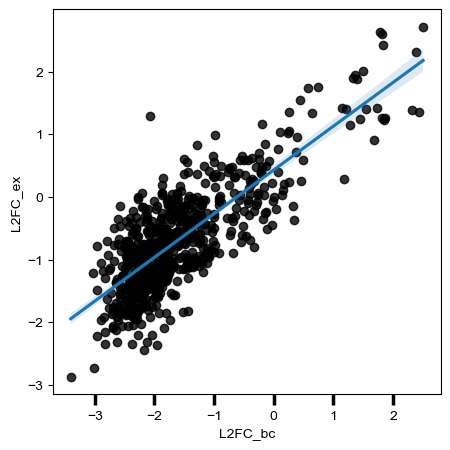

In [18]:
f, ax = plt.subplots(figsize = (5, 5))
sns.regplot(
    data = toplot, 
    x = 'L2FC_bc', 
    y = 'L2FC_ex', 
    scatter_kws = {'color': 'black'},
    ax = ax
)

ticks = [-3, -2, -1, 0, 1, 2]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

f.savefig('PLOTS/Fig_S1A.pdf', transparent = True)

## Supplementary Figure S1D: length histogram from long read sequencing

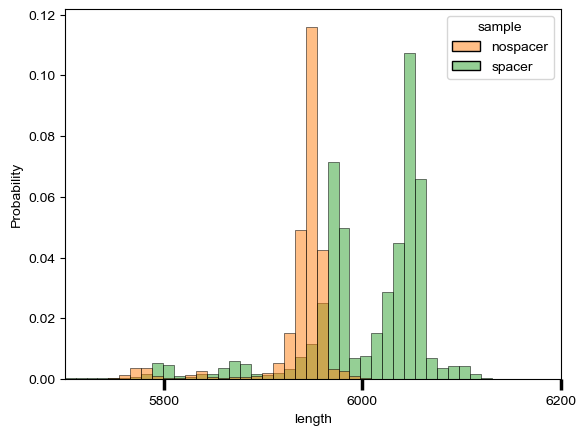

In [19]:
length = pd.read_csv('data/plasmidsaurus_length_distribution.txt', sep = '\t', names = ['sample', 'length'])
length = length[(length['length']>5500)&(length['length']<6500)]

f, ax = plt.subplots()

sns.histplot(data = length, x = 'length', hue = 'sample', palette = sns.color_palette()[1:3],
             stat = 'probability', hue_order = ['nospacer', 'spacer'], ax = ax)

ax.set_xlim(5700, 6200)
ax.set_xticks([5800, 6000, 6200])

f.savefig('PLOTS/Fig_S1D.pdf', transparent = True)

## Supplementary Figure S1E: Fraction of palindromic reads by reporter in DNA sample

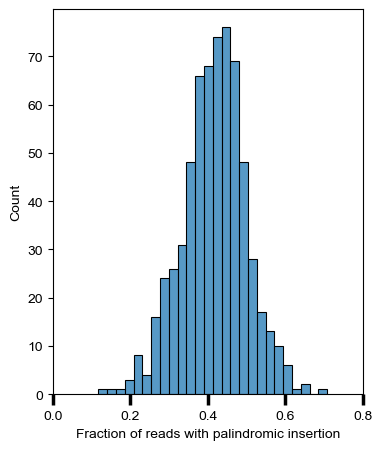

In [20]:
nanopore = pd.read_csv('data/long_read_seq_report.txt', sep = '\t',
                      names = ['read', 'length', 'type', 'reporter', 'palindrome', 'duplication'])

nanopore = nanopore[(5800<nanopore['length'])&(nanopore['length']<6200)]
nanopore = nanopore.dropna()

nanopore['RE'] = nanopore['reporter'].apply(lambda g: g.split('_')[0])

toplot = nanopore.groupby('RE')['palindrome'].value_counts(normalize=True).to_frame(name='per').reset_index()
toplot = toplot[toplot['palindrome']=='yes']
#toplot = toplot[toplot['RE'].isin(test.index)]

f, ax = plt.subplots(figsize = (4, 5))

sns.histplot(data = toplot, x = 'per', ax = ax)

ax.set_xlabel('Fraction of reads with palindromic insertion')

xticks = ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])

f.savefig('PLOTS/Fig_S1E.pdf', transparent = True)

## Supplementary Figure S1F: Palindromic insert does not correlate with reporter expression

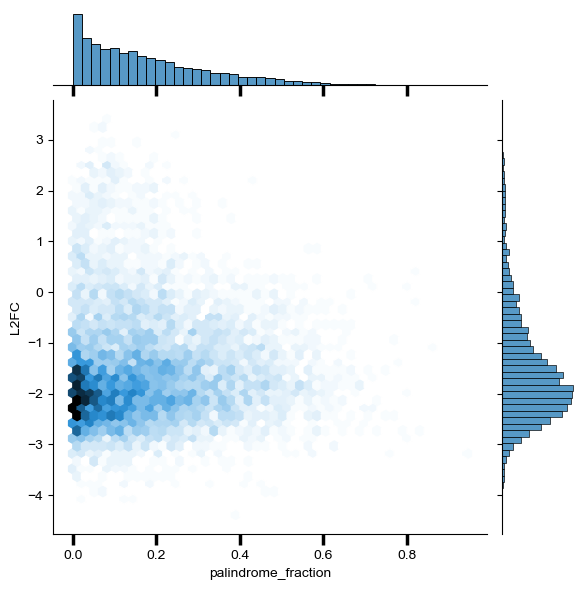

In [21]:
def compute_palindrome(fn):
    df = pd.read_csv(fn, sep = '\t')
    df['fraction'] = df.groupby('best_reporter')['count'].transform(lambda g: g/g.sum()) 
    df = df[df['best_category']=='palindrome'].reset_index(drop = True)
    return df

hela1_pan = compute_palindrome('data/HELA-1_palindrome_count.txt')
hela2_pan = compute_palindrome('data/HELA-2_palindrome_count.txt')
hela_pan = hela1_pan.merge(hela2_pan, on = 'best_reporter', suffixes = ('_1', '_2'), how = 'outer')
hela_pan = hela_pan.fillna(0)
hela_pan['palindrome_fraction'] = hela_pan[['fraction_1', 'fraction_2']].mean(axis = 1)

ptreseq_count_barcode = ptreseq_count.groupby('reporter')['L2FC'].median().to_frame().reset_index()

m = hela_pan.merge(ptreseq_count_barcode, left_on = 'best_reporter', right_on = 'reporter', how = 'outer')
m['palindrome_fraction'] = m['palindrome_fraction'].fillna(0)

j = sns.jointplot(data = m, x = 'palindrome_fraction', y = 'L2FC', kind = 'hex')

j.savefig('PLOTS/Fig_S1F.pdf')

## Supplementary Figure S1G: Compare expression between full PTRE-seq library and no-spacer library

In [22]:
# calculate relative RNA expression using measurements from extended primers
def calculate_CPM(fn):
    df = pd.read_csv(fn, sep = '\t')
    df = df[df['reporter']!='-1']
    df['RE_Identity'] = df['reporter'].apply(lambda g: g.split('_')[0])
    df = df.groupby('RE_Identity').sum(numeric_only = True).reset_index()
    df['CPM'] = df['count']*1000000/df['count'].sum()
    return df

# read input RNA count measured using extended primers
hela_nospacer = calculate_CPM('ptreseq_raw_count/HELA-nospacer_raw_count.txt')

# read input DNA count measured using extended primers
dna_nospacer = calculate_CPM('ptreseq_raw_count/DNA-nospacer_raw_count.txt')

# normalize RNA count by DNA count
nospacer_count = hela_nospacer[
    ['RE_Identity', 'CPM']
].merge(
    dna_nospacer[['RE_Identity', 'CPM']], 
    on = 'RE_Identity', suffixes = ('_RNA', '_DNA')
)

nospacer_count['RNA/DNA'] = nospacer_count['CPM_RNA']/nospacer_count['CPM_DNA']
#nospacer_count['RNA/DNA'] = nospacer_count['CPM_RNA']

# Calculate BBBB median and normalize expression
BBBB = nospacer_count[nospacer_count['RE_Identity']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()
# normalized by median of BBBB normalized count
nospacer_count['normEXP'] = nospacer_count['RNA/DNA']/median_exp
nospacer_count['L2FC'] = np.log2(nospacer_count['RNA/DNA']/median_exp)

               L2FC_full  L2FC_nospacer
L2FC_full       1.000000       0.680891
L2FC_nospacer   0.680891       1.000000


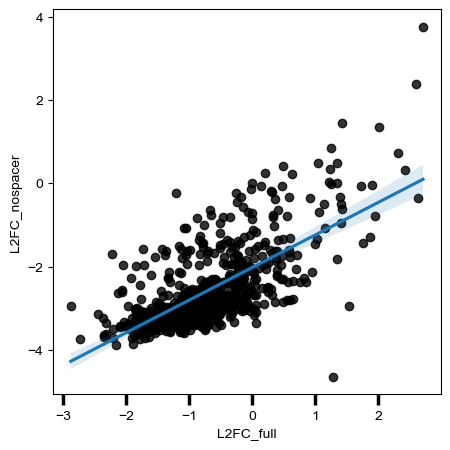

In [23]:
m = extended_count.merge(nospacer_count, on = 'RE_Identity', suffixes = ('_full', '_nospacer'))
print(m[['L2FC_full', 'L2FC_nospacer']].corr())

f, ax = plt.subplots(figsize = (5, 5))

sns.regplot(data = m, x = 'L2FC_full', y = 'L2FC_nospacer', scatter_kws = {'color': 'black'}, ax = ax)

f.savefig('PLOTS/Fig_S1G.pdf', transparent = True)

## Supplementary Figure S1H: tape station no spacer library

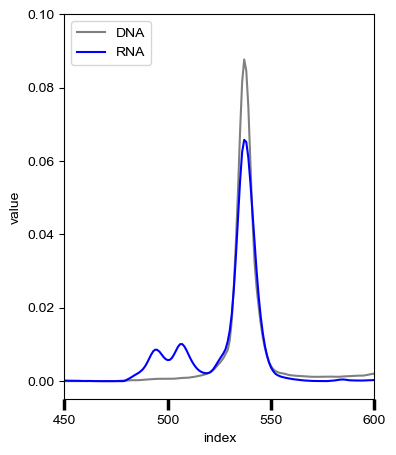

In [25]:
# read tape station data for "no spacer" library
df1 = pd.read_csv('data/2020-11-16 - HELA no spacer_Electropherogram.csv', sep = ',')
df1 = df1.reset_index()

df2 = pd.read_csv('data/2023-07-21 - DNA no spacer_Electropherogram.csv', sep = ',')
df2 = df2.reset_index()
df2['index'] = df2['index'] - 7

df3 = df1.merge(df2, on = 'index')

dnacol = 'B1: RELIB_PCR2_50'
rnacol = 'A1: RT'

toplot2 = df3[['index', dnacol, rnacol]].reset_index(drop=True)

# normalize peak by area under the line
toplot2['DNA'] = toplot2[dnacol]/np.trapz(toplot2.iloc[200:600][dnacol].to_numpy(), dx=1)
toplot2['RNA'] = toplot2[rnacol]/np.trapz(toplot2.iloc[200:600][rnacol].to_numpy(), dx=1)
# convert DF from wide to long
toplot2 = pd.melt(toplot2, value_vars = ['DNA', 'RNA'], id_vars = 'index')

# plot normalized electropherogram 
f, ax = plt.subplots(figsize = (4, 5))

sns.lineplot(data = toplot2, x = 'index', y = 'value', hue = 'variable', 
             palette = ['grey', 'blue'], ax = ax)

ax.set_xlim(460, 600)
ax.set_ylim(-0.005, 0.10)
ax.legend(title = '', loc = 'upper left')

ax.set_xticks([i for i in range(450, 650, 50)])

f.savefig('PLOTS/Fig_S1H.pdf')

## Figure 1E and Supplementary Figure 2C: piechart showing distribution of read assignments

In [64]:
# classify reads into 7 categories 
order = ['full_length',  
        'spliced',          
        'incomplete cloning',
        'panlidromic indel',              
        'mis-priming',                       
        'recombination',
        'ambiguous']   

def replace_category(cat):
    # function to rename reads into one of the categories
    if 'spliced' in cat:
        return 'spliced'
    elif 'AG_junction_high_mismatch' in cat or cat == 'ambiguous_deletion' or cat == 'unidentifiable_barcode':
        return 'ambiguous'
    elif cat == 'PRE-SPACER_mispriming' or cat == 'blank_mispriming':
        return 'mis-priming'
    elif cat == 'spacer_not_cloned' or cat == 'RE_not_cloned':
        return 'incomplete cloning'
    # NOTE: palindromic insertion was called RT_error in the original script, hence why I replace RT_error with the panlindromic indel
    elif cat == 'RT_error' or cat == 'palindrome':
        return 'panlidromic indel'
    elif cat == 'PCR_chimera':
        return 'recombination'
    else:
        return cat

def calculate_class_count(data):
    # function to count number of reads for each category
    if type(data) == str:
        df = pd.read_csv(data, sep = '\t')
    else:
        df = data
    
    df['best_category'] = df['best_category'].apply(lambda g: replace_category(g))
    df = df.groupby('best_category')['count'].sum()
    #print(df)
    #print('total read count =', df.sum())
    df = df/df.sum()
    df = df.reindex(order)
    
    return df

In [65]:
# DNA plasmids
dna1 = calculate_class_count('ptreseq_raw_count/DNA-1_raw_count.txt')
dna2 = calculate_class_count('ptreseq_raw_count/DNA-2_raw_count.txt')

# calculate average percentage
dna = (dna1 + dna2)/2
dna

best_category
full_length           0.701464
spliced               0.000364
incomplete cloning    0.082181
panlidromic indel     0.000534
mis-priming           0.103413
recombination         0.072327
ambiguous             0.039718
Name: count, dtype: float64

In [66]:
# HELA (SSII)
hela1 = calculate_class_count('ptreseq_raw_count/HELA-1_raw_count.txt')
hela2 = calculate_class_count('ptreseq_raw_count/HELA-2_raw_count.txt')

# calculate average percentage
hela = (hela1 + hela2)/2
hela

best_category
full_length           0.299204
spliced               0.192836
incomplete cloning    0.173100
panlidromic indel     0.137171
mis-priming           0.076179
recombination         0.046513
ambiguous             0.074997
Name: count, dtype: float64

In [67]:
# HELA (Marathon RT)
mara1 = calculate_class_count('ptreseq_raw_count/ETOH-1_raw_count.txt')
mara2 = calculate_class_count('ptreseq_raw_count/ETOH-2_raw_count.txt')

# calculate average percentage
mara = (mara1 + mara2)/2
mara

best_category
full_length           0.295553
spliced               0.241250
incomplete cloning    0.105079
panlidromic indel     0.003189
mis-priming           0.081515
recombination         0.036380
ambiguous             0.237035
Name: count, dtype: float64

In [68]:
# HEK 293 (SSII)
hek1 = calculate_class_count('ptreseq_raw_count/HEK-1_raw_count.txt')
hek2 = calculate_class_count('ptreseq_raw_count/HEK-2_raw_count.txt')
hek3 = calculate_class_count('ptreseq_raw_count/HEK-3_raw_count.txt')

# calculate average percentage
hek = (hek1 + hek2 + hek3)/3
hek

best_category
full_length           0.362660
spliced               0.159286
incomplete cloning    0.153797
panlidromic indel     0.053758
mis-priming           0.074827
recombination         0.065642
ambiguous             0.130030
Name: count, dtype: float64

In [69]:
# SH-SY5Y (SSII)
sh1 = calculate_class_count('ptreseq_raw_count/SH-1_raw_count.txt')
sh2 = calculate_class_count('ptreseq_raw_count/SH-2_raw_count.txt')
sh3 = calculate_class_count('ptreseq_raw_count/SH-3_raw_count.txt')

# calculate average percentage
sh = (sh1 + sh2 + sh3)/3
sh

best_category
full_length           0.317403
spliced               0.168313
incomplete cloning    0.165334
panlidromic indel     0.056663
mis-priming           0.094319
recombination         0.061897
ambiguous             0.136071
Name: count, dtype: float64

In [70]:
# U87 (SSII)
u871 = calculate_class_count('ptreseq_raw_count/U87-1_raw_count.txt')
u872 = calculate_class_count('ptreseq_raw_count/U87-2_raw_count.txt')
u873 = calculate_class_count('ptreseq_raw_count/U87-3_raw_count.txt')

# calculate average percentage
u87 = (u871 + u872 + u873)/3
u87

best_category
full_length           0.355011
spliced               0.154052
incomplete cloning    0.159535
panlidromic indel     0.048148
mis-priming           0.089517
recombination         0.061727
ambiguous             0.132010
Name: count, dtype: float64

In [71]:
# DNA alt protocol with palindrome
dna_alt = calculate_class_count('ptreseq_raw_count/DNA-altprotocol_raw_count.txt')

In [72]:
# HELA alt protocol 
hela_alt = calculate_class_count('ptreseq_raw_count/HELA-cPCR_raw_count.txt')

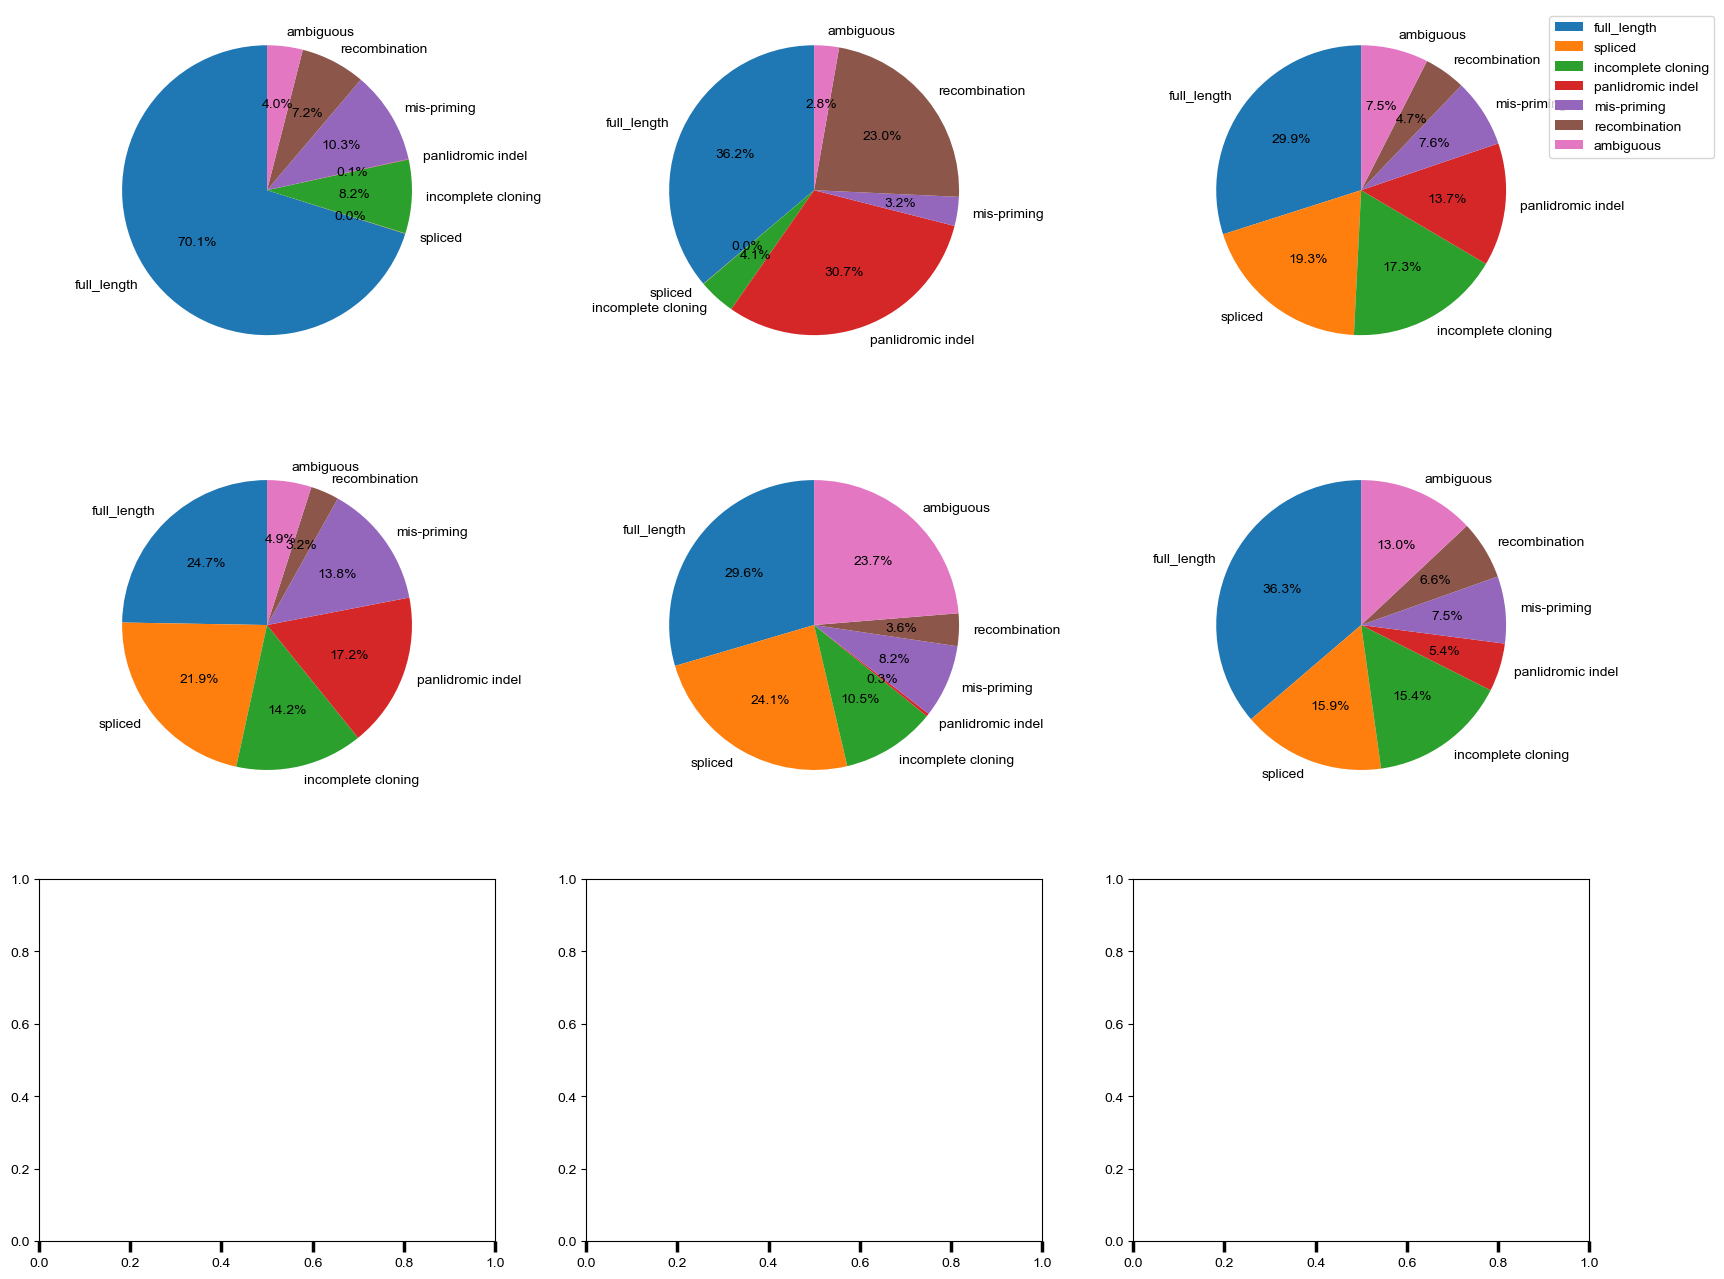

In [73]:
f, (top, middle, bottom) = plt.subplots(ncols = 3, nrows = 3, figsize = (20, 16))

# DNA prep I
dna.plot.pie(y = 'count', ax = top[0], ylabel = '', startangle = 90, autopct='%1.1f%%')
# DNA prep II
dna_alt.plot.pie(y = 'count', ax = top[1], ylabel = '', startangle = 90, autopct='%1.1f%%')
# HELA (SSII prep I)
hela.plot.pie(y = 'count', ax = top[2], ylabel = '', startangle = 90, autopct='%1.1f%%')
# HELA (SSII prep II)
hela_alt.plot.pie(y = 'count', ax = middle[0], ylabel = '', startangle = 90, autopct='%1.1f%%')
# HELA (Marathon prep II)
mara.plot.pie(y = 'count', ax = middle[1], ylabel = '', startangle = 90, autopct='%1.1f%%')
# HEK
hek.plot.pie(y = 'count', ax = middle[2], ylabel = '', startangle = 90, autopct='%1.1f%%')

# SH and U87 are not shown in manuscript
#sh.plot.pie(y = 'count', ax = bottom[0], ylabel = '', startangle = 90, autopct='%1.1f%%') 
#u87.plot.pie(y = 'count', ax = bottom[1], ylabel = '', startangle = 90, autopct='%1.1f%%')
top[2].legend(bbox_to_anchor = (1, 1))

f.savefig('PLOTS/Fig_S2C.pdf', transparent = True)

## Figure S2E: comparison between prep I and prep II

               fraction_cpcr  fraction_epcr
fraction_cpcr       1.000000       0.990867
fraction_epcr       0.990867       1.000000


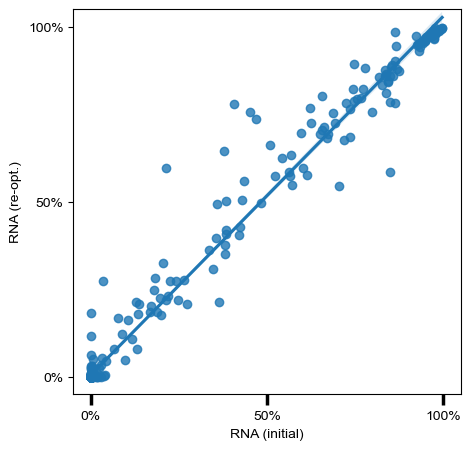

In [74]:
hela_cpcr = pd.read_csv('ptreseq_splicing_quantification/HELA-cPCR_1rep_fraction.txt', sep = '\t')
hela_cpcr = hela_cpcr[hela_cpcr['best_category']=='full_length'].reset_index(drop = True)
hela_cpcr['fraction'] = 1 - hela_cpcr['fraction']

hela_epcr = pd.read_csv('ptreseq_splicing_quantification/HELA-ePCR_1rep_fraction.txt', sep = '\t')
hela_epcr = hela_epcr[hela_epcr['best_category']=='full_length'].reset_index(drop = True)
hela_epcr['fraction'] = 1 - hela_epcr['fraction']

merged = hela_cpcr.merge(hela_epcr, on = ['RE', 'best_category'], suffixes = ('_cpcr', '_epcr'))
print(merged.corr(numeric_only = True))

# regplot
f, ax = plt.subplots(figsize = (5, 5))

sns.regplot(data = merged, x = 'fraction_epcr', y = 'fraction_cpcr', ax = ax)

ax.set_ylabel('RNA (re-opt.)')
ax.set_xlabel('RNA (initial)')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S2E.pdf')

## Figure S2F: comparison between SuperScript II and Marathon

In [75]:
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
fHELA = HELA[HELA['best_category']=='full_length'].reset_index(drop = True)
fHELA['fraction'] = 1 - fHELA['fraction']

MARA = pd.read_csv('ptreseq_splicing_quantification/HELA-mara_2rep_fraction.txt', sep = '\t')
fMARA = MARA[MARA['best_category']=='full_length'].reset_index(drop = True)
fMARA['fraction'] = 1 - fMARA['fraction']

merged = fHELA.merge(fMARA, on = ['RE', 'best_category'], suffixes = ('_ssii', '_mara'))
merged.corr(numeric_only = True)

,fraction_ssii,fraction_mara
fraction_ssii,1.000000,0.960483
fraction_mara,0.960483,1.000000


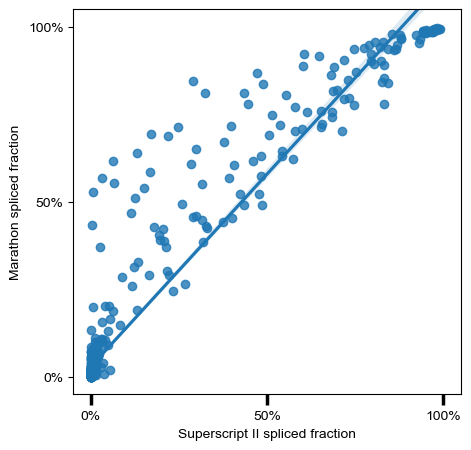

In [76]:
# regplot
f, ax = plt.subplots(figsize = (5, 5))

sns.regplot(data = merged, x = 'fraction_ssii', y = 'fraction_mara', ax = ax)

ax.set_xlabel('Superscript II spliced fraction')
ax.set_ylabel('Marathon spliced fraction')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S2F.pdf')

## Figure S2G: comparison between no spacer library and PTRE-seq library

In [77]:
# full ptre-seq library
ptreseq = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

spacer_dict = {}
for RE in ptreseq['RE'].unique():
    temp = ptreseq[ptreseq['RE']==RE]
    temp = temp[temp['best_category']!='full_length']

    isoform = temp.loc[temp['fraction']==temp['fraction'].max(), 'best_category']

    if not isoform.empty:
        if 'CTCCGA_319' in isoform.values[0]:
            spacer_dict[RE] = 'spacer'
        elif 257 < int(isoform.values[0].split('_')[3]) < 290:
            spacer_dict[RE] = '4th RE module'
        else:
            spacer_dict[RE] = 'other'
    else:
        spacer_dict[RE] = 'other'
        
ptreseq['acceptor'] = ptreseq['RE'].apply(lambda g: spacer_dict[g])
ptreseq['fraction'] = 1 - ptreseq['fraction']
ptreseq = ptreseq[ptreseq['best_category']=='full_length'].reset_index(drop = True)

# no spacer library
nospacer = pd.read_csv('ptreseq_splicing_quantification/HELA-nospacer_1rep_fraction.txt', sep = '\t')
nospacer['fraction'] = 1 - nospacer['fraction']
nospacer = nospacer[nospacer['best_category']=='full_length'].reset_index(drop = True)

merged = ptreseq.merge(nospacer, on = ['RE', 'best_category'], suffixes = ('_ptreseq', '_nospacer'))
merged.corr(numeric_only = True)

,fraction_ptreseq,fraction_nospacer
fraction_ptreseq,1.000000,0.892263
fraction_nospacer,0.892263,1.000000


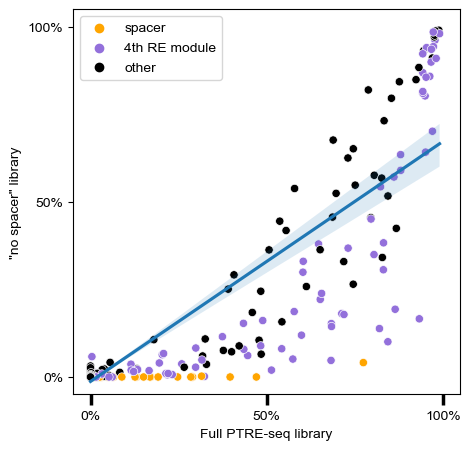

In [78]:
# regplot
f, ax = plt.subplots(figsize = (5, 5))

sns.scatterplot(data = merged, x = 'fraction_ptreseq', y = 'fraction_nospacer', hue = 'acceptor', 
                hue_order = ['spacer', '4th RE module', 'other'],
                palette = ['orange', 'mediumpurple', 'black'], ax = ax)

sns.regplot(data = merged, x = 'fraction_ptreseq', y = 'fraction_nospacer', scatter = False, ax = ax)

ax.set_xlabel('Full PTRE-seq library')
ax.set_ylabel('"no spacer" library')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

ax.legend(title = '')

f.savefig('PLOTS/Fig_S2G.pdf')

## Figure S2H: reproducibility between biological replicates of HeLa (SSII) sample

In [79]:
def process_raw_count(fn, sample):
    df = pd.read_csv(fn, sep = '\t')
    df = df[(df['best_category'].str.contains('full_length'))|(df['best_category'].str.contains('spliced'))].reset_index(drop = True)
    df['best_category'] = df['best_category'].apply(lambda g: g.split('-')[1] if 'spliced' in g else g)
    
    # get total count for each reporter and remove reporters with count less than 10
    total_count = df.groupby('reporter')['count'].sum()
    reporter_less_than_10 = total_count[total_count<=10].index
    filtered_df = df[~df['reporter'].isin(reporter_less_than_10)].reset_index(drop = True)
    
    # calculate fraction for each isoform
    filtered_df['fraction'] = filtered_df.groupby('reporter', group_keys=False)['count'].apply(lambda g: g/g.sum())
    # calculate fraction over barcode replicates
    filtered_df['RE'] = filtered_df['reporter'].apply(lambda g: g.split('_')[0])
    
    return filtered_df

def filter_barcode_count(df, threshold):
    # filter out reporters with less than 2 internal barcodes
    full_df = df[df['best_category']=='full_length']
    
    RE_count = full_df['RE'].value_counts()
    reporter_less_than_3_count = RE_count[RE_count<=threshold].index
    filtered_df = full_df[~full_df['RE'].isin(reporter_less_than_3_count)].reset_index(drop = True)
    
    return filtered_df

In [80]:
# import raw count
hela1count = process_raw_count('ptreseq_raw_count/HELA-1_raw_count.txt', 'hela1')
hela2count = process_raw_count('ptreseq_raw_count/HELA-2_raw_count.txt', 'hela2')
# merge dataframe
hela = hela1count.merge(hela2count, on = ['reporter', 'RE', 'best_category'], how = 'inner')
hela = hela.rename(columns = {
                        'count_x': 'HELA-1_count',
                        'fraction_x': 'HELA-1_fraction',
                        'count_y': 'HELA-2_count',
                        'fraction_y': 'HELA-2_fraction'
                            })
# filter out reporters with less than 2 internal barcodes
hela_filtered = filter_barcode_count(hela, 2)
# compute median splicing fraction
hela_filtered = hela_filtered.groupby('RE')[['HELA-1_fraction', 'HELA-2_fraction']].median()
# splicing fraction = 1 - full length fraction
hela_filtered['HELA-1'] = 1 - hela_filtered['HELA-1_fraction']
hela_filtered['HELA-2'] = 1 - hela_filtered['HELA-2_fraction']

          HELA-1    HELA-2
HELA-1  1.000000  0.976964
HELA-2  0.976964  1.000000


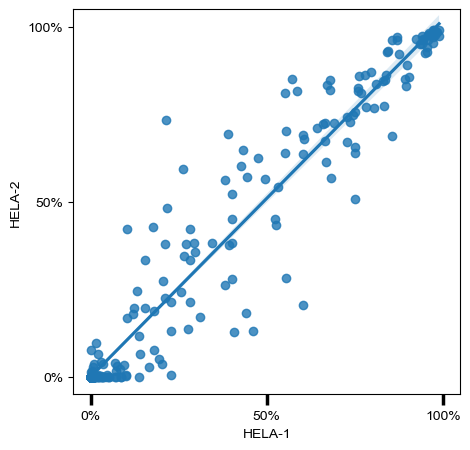

In [81]:
# plot correlation between 2 hela biological replicates
f, ax = plt.subplots(figsize = (5, 5))

print(hela_filtered[['HELA-1', 'HELA-2']].corr())

sns.regplot(data = hela_filtered, x = 'HELA-1', y = 'HELA-2', ax = ax)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S2H.pdf')

## Supplementary Figure S2I: mean absolute deviation between barcodes

In [82]:
# calculate mean absolute deviation
hela_concat = pd.concat([hela1count, hela2count])
hela_concat_fl = hela_concat[hela_concat['best_category']=='full_length'].reset_index(drop = True)
hela_concat_fl['spliced_fraction'] = 1 - hela_concat_fl['fraction']
hela_concat_fl_mad = hela_concat_fl.groupby('RE')['spliced_fraction'].apply(
    lambda g: (g - g.mean()).abs().mean())

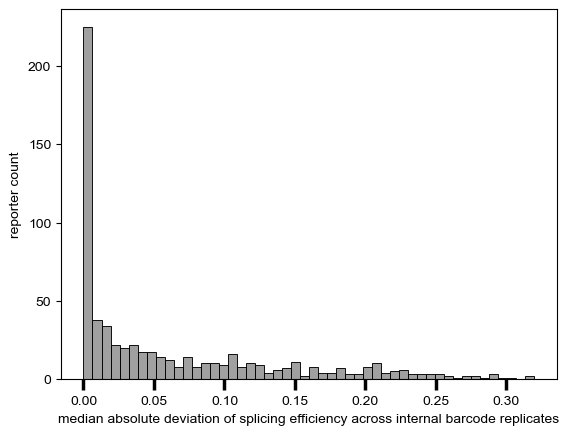

In [83]:
# plot histogram
f, ax = plt.subplots()

sns.histplot(x = hela_concat_fl_mad, color = 'grey', bins = 50, ax = ax)

ax.set_xlabel('median absolute deviation of splicing efficiency across internal barcode replicates')
ax.set_ylabel('reporter count')

f.savefig('PLOTS/Fig_S2I.pdf')